# Chapter 3

In [6]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt

import arviz as az

import jax.numpy as jnp
from jax import random

from scipy.stats import gaussian_kde

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation

## Sampling from grid-approximate posterior, Code 3.2-3.5

In [2]:
p_grid = np.linspace(0, 1, 1000)

# define prior - uniform
prior = np.repeat(1, 1000)

# compute likelihood at each value in grid
# log_prob calculates the log probabilities of observed 6 wins out of 9 samples
# for the different probabilities
likelihood = jnp.exp(dist.Binomial(total_count=9, probs=p_grid).log_prob(6))

# product of likelihood and prior 
unstd_posterior = likelihood * prior

# standardize by evidence, marginal likelihood
posterior = unstd_posterior / jnp.sum(unstd_posterior)


In [3]:
n_samples=20000
# Samples are integers from {0,…,K−1}\{0, \ldots, K-1\}{0,…,K−1} where K is probs.size(-1).
# If probs is 1-dimensional with length-K, each element is the relative probability of sampling the class at that index.
samples = p_grid[dist.Categorical(probs=posterior).sample(random.PRNGKey(0), (n_samples,))]

In [63]:
rng = default_rng(seed=42)
samples_np = rng.choice(p_grid, n_samples, p=np.array(posterior))

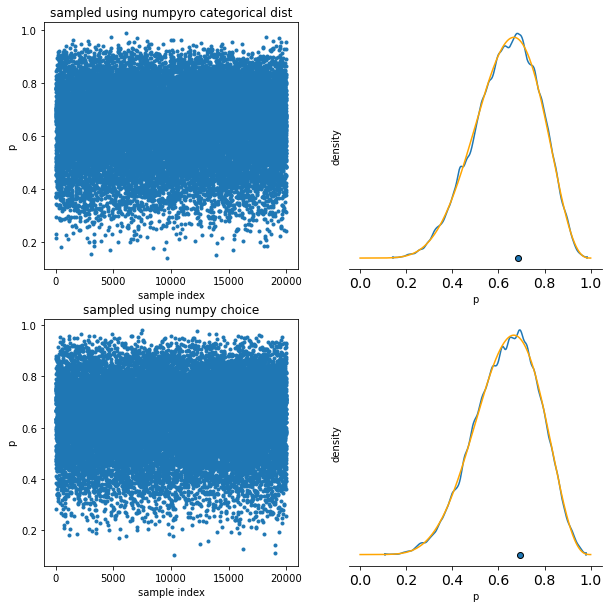

In [72]:
fig, ax = plt.subplots(2,2, figsize=(10, 10))
ax[0,0].plot(samples, marker='.', linestyle = 'None')
ax[0,0].set_title('sampled using numpyro categorical dist')
ax[0,0].set_xlabel('sample index')
ax[0,0].set_ylabel('p');

az.plot_density({"": samples}, hdi_prob=1, ax=ax[0,1], point_estimate='mode');
ax[0,1].plot(p_grid, 1000*posterior, color='orange')
ax[0,1].set_xlabel('p')
ax[0,1].set_ylabel('density');

ax[1,0].plot(samples_np, marker='.', linestyle = 'None')
ax[1,0].set_title('sampled using numpy choice')
ax[1,0].set_xlabel('sample index')
ax[1,0].set_ylabel('p');

az.plot_density({"": samples_np}, hdi_prob=1, ax=ax[1,1], point_estimate='mode');
ax[1,1].plot(p_grid, 1000*posterior, color='orange')
ax[1,1].set_xlabel('p')
ax[1,1].set_ylabel('density');


## Sampling to summarize, Code 3.6-3.19

### Intervals of defined boundaries

In [73]:
# posterior prob that p_water is < 0.5
# use grid approximated posterior
print(posterior[p_grid<0.5].sum())
# use samples
samples[samples<0.5].shape[0]/samples.shape[0]

DeviceArray(0.17187458, dtype=float32)

In [78]:
# posterior that lies between 0.5 and 0.75
samples[(samples>=0.5) & (samples<0.75)].shape[0]/samples.shape[0]

0.60375

### Intervals of defined mass

In [83]:
# boundaries that contain lower 80% posterior prob
print(jnp.quantile(samples, 0.8))
# boundaries that contain 10%-90% posterior prob
print(jnp.quantile(samples, jnp.array([0.1, 0.9])))
# boundaries that contain 25%-75% posterior prob
print(jnp.quantile(samples, jnp.array([0.25, 0.75])))


0.7607608
[0.44444445 0.8118118 ]
[0.5415415 0.7397397]


In [82]:
# highest posterior density interval (HPDI)
numpyro.diagnostics.hpdi(samples, prob=0.5)

array([0.56956957, 0.76376376])

### Point estimates

In [100]:
# maxium a posteriori (MAP) - parameter with highest posterior prob = mode
# returns the mode of a posterior distribution
print(p_grid[jnp.argmax(posterior)])
# use samples
# density estimate, return density for each sample, find maximum density sample
mode = samples[jnp.argmax(gaussian_kde(samples, bw_method=0.01)(samples))]
mode

0.6666666666666666


0.6766766766766766

In [92]:
# mean and median are also point estimates
print(samples.mean(), np.median(samples))

0.6360051051051051 0.6456456456456456


In [96]:
# calculate loss if we choose p=0.5
# difference of all p's in posterior (approx by grid) to the chosen value
# weighted by the posterior prob
# => weighted average loss
print(np.sum(posterior * np.abs(0.5-p_grid)))
print(np.sum(posterior * np.abs(0.66-p_grid)))
loss = [np.sum(posterior * np.abs(i-p_grid)) for i in p_grid]

0.16406262
0.1132783


In [104]:
p_grid[jnp.argmin(np.array(loss))]

0.6446446446446447

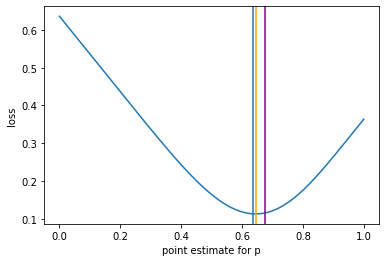

In [102]:
plt.plot(p_grid, loss);
plt.xlabel('point estimate for p')
plt.ylabel('loss')
plt.axvline(samples.mean())
plt.axvline(np.median(samples), color='orange')
plt.axvline(mode, color='purple');

## Sampling to simulate prediction, Code 3.20-3.26

### Dummy data

In [107]:
# generate 100,000 dummy observations of water/land
# use the likelihood function with a given probability
dummy_w = dist.Binomial(total_count=9, probs=0.7).sample(random.PRNGKey(0), (100000,))
jnp.unique(dummy_w, return_counts=True)[1] / 1e5

DeviceArray([1.0000e-05, 4.1000e-04, 3.8600e-03, 2.0900e-02, 7.3330e-02,
             1.7241e-01, 2.6379e-01, 2.6600e-01, 1.5846e-01, 4.0830e-02],            dtype=float32, weak_type=True)

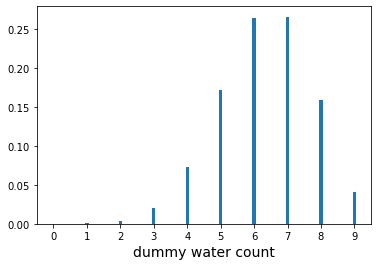

In [109]:
ax = az.plot_dist(dummy_w.copy(), kind="hist", hist_kwargs={"rwidth": 0.1})
ax.set_xlabel("dummy water count", fontsize=14)
plt.show()

### Is the model adequate?

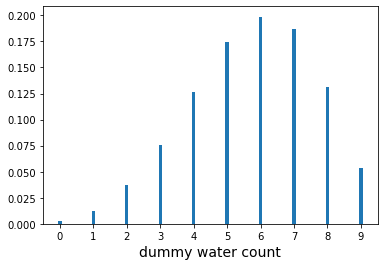

In [ ]:
# now sample not with a chosen probability but using the posterior samples for p_water
dummy_w = dist.Binomial(total_count=9, probs=samples).sample(random.PRNGKey(0), (5, ))
ax = az.plot_dist(dummy_w.flatten().copy(), kind="hist", hist_kwargs={"rwidth": 0.1})
ax.set_xlabel("dummy water count", fontsize=14)
plt.show()

In [50]:
# use different metrics to evaluate the model, e.g. to investigate if observations are independent
# or if they are correlated
# 1. number of waters in a row, e.g. in the true observation we see WLWWWLWLW
# sample toss sequences

In [15]:
# sample 9 independent tosses using the different probabilities
dummy_seq = dist.Binomial(total_count=1, probs=samples).sample(random.PRNGKey(0), (9, ))

In [36]:
from itertools import groupby
# count how often water (=1) appears consecutively
L = dummy_seq
consect_waters = [max(sum(1 for i in g) if k==1 else 0 for k,g in groupby(L[:, j])) for j in range(L.shape[1])]

In [49]:
# count how often observations alternate between water and earth
alternations = [sum(1 for k,g in groupby(L[:, j]))-1 for j in range(L.shape[1])]

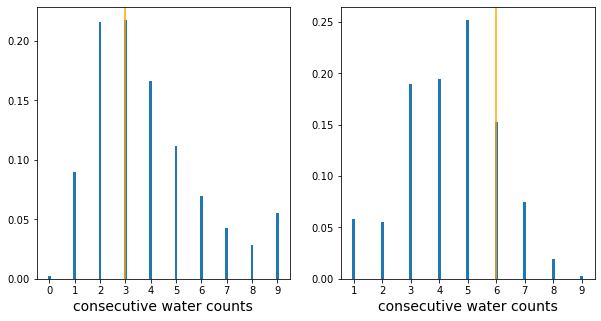

In [48]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
az.plot_dist(np.array(consect_waters), kind="hist", hist_kwargs={"rwidth": 0.1}, ax=ax[0])
ax[0].set_xlabel("consecutive water counts", fontsize=14)
ax[0].axvline(3, color='orange')
                       
az.plot_dist(np.array(alternations), kind="hist", hist_kwargs={"rwidth": 0.1}, ax=ax[1])
ax[1].set_xlabel("consecutive water counts", fontsize=14)
ax[1].axvline(6, color='orange');              


## Exercises

### 3H1

In [2]:
birth1 = [
    1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
    0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
    1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
    0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1]
birth2 = [
    0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
    0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
    0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]

In [32]:
# number of boys
n_boys_100 = sum(birth1)
n_boys_200 = sum(birth1) + sum(birth2)
print(n_boys_100)
print(n_boys_200)

51
111


In [7]:
# probability of being a boy
# boy = 1, girl = 0
p_grid = np.linspace(0, 1, 1000)

# define prior - uniform
prior = np.repeat(1, 1000)

# compute likelihood at each value in grid
# log_prob calculates the log probabilities of observing 111 boys in all 200 children
# for the different probabilities
likelihood = jnp.exp(dist.Binomial(total_count=200, probs=p_grid).log_prob(111))

# product of likelihood and prior 
unstd_posterior = likelihood * prior

# standardize by evidence, marginal likelihood
posterior = unstd_posterior / jnp.sum(unstd_posterior)


In [11]:
# maxium a posteriori (MAP) - parameter with highest posterior prob = mode
# returns the mode of a posterior distribution
mode = p_grid[jnp.argmax(posterior)]
print(mode)

0.5545545545545546


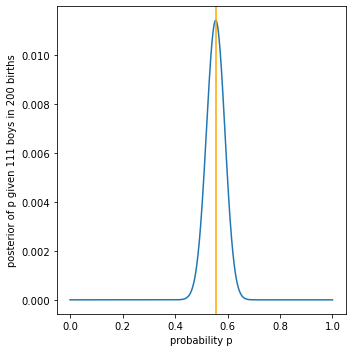

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

ax.plot(p_grid, posterior)
ax.set_xlabel('probability p')
ax.set_ylabel('posterior of p given 111 boys in 200 births')
ax.axvline(mode, color='orange')
plt.tight_layout()

### 3H2

In [15]:
n_samples=10000
samples = p_grid[dist.Categorical(probs=posterior).sample(random.PRNGKey(0), (n_samples,))]

In [16]:
print(numpyro.diagnostics.hpdi(samples, prob=0.5))
print(numpyro.diagnostics.hpdi(samples, prob=0.89))
print(numpyro.diagnostics.hpdi(samples, prob=0.97))

[0.53053053 0.57757758]
[0.5005005  0.61261261]
[0.48048048 0.63263263]


### 3H3

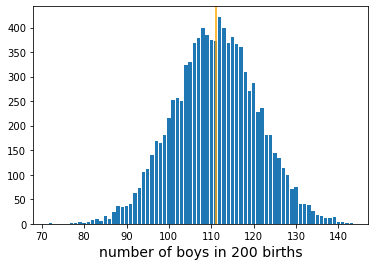

In [31]:
total_births = 200
dummy_w = dist.Binomial(total_count=total_births, probs=samples).sample(random.PRNGKey(0))
vals = np.unique(dummy_w)
bins = np.append(vals, vals.max()+1)
h, bins = np.histogram(dummy_w, bins=bins)
fig, ax = plt.subplots(1,1)
ax.bar(vals, h)
ax.set_xlabel(f"number of boys in {total_births} births", fontsize=14)
ax.axvline(111, color='orange')
plt.show()

### 3H4

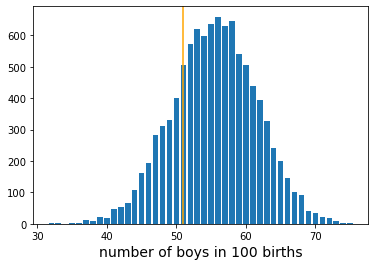

In [33]:
total_births=100
dummy_w = dist.Binomial(total_count=total_births, probs=samples).sample(random.PRNGKey(0))
vals = np.unique(dummy_w)
bins = np.append(vals, vals.max()+1)
h, bins = np.histogram(dummy_w, bins=bins)
fig, ax = plt.subplots(1,1)
ax.bar(vals, h)
ax.set_xlabel(f"number of boys in {total_births} births", fontsize=14)
ax.axvline(n_boys_100, color='orange')
plt.show()

### 3H5

In [44]:
# number of boys following girls
n_boys_aftergirls = sum(np.array(birth2)[np.where(np.array(birth1)<1)])

In [47]:
n_boys_aftergirls

39

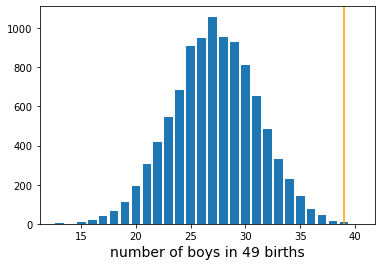

In [46]:
# simulate number of boys born after first born was a girl
# number of first born girls
total_births = len(birth1) - n_boys_100
dummy_w = dist.Binomial(total_count=total_births, probs=samples).sample(random.PRNGKey(0))
vals = np.unique(dummy_w)
bins = np.append(vals, vals.max()+1)
h, bins = np.histogram(dummy_w, bins=bins)
fig, ax = plt.subplots(1,1)
ax.bar(vals, h)
ax.set_xlabel(f"number of boys in {total_births} births", fontsize=14)
ax.axvline(n_boys_aftergirls, color='orange')
plt.show()